# Pre-training

As in (Harsuko and Alkhalifah, 2022), pre-training of StorSeismic was intended to make the network learn the "features" of a seismic data. In this notebook, we will use the masked seismic data as the input and train the network to reconstruct the masked traces. The backbone of the network is BERT architecture (Devlin et al., 2018), obtained from HuggingFace's <code>transformers</code> library (https://github.com/huggingface/transformers).

## Load required modules

In [1]:
#!pip install git
!pip install git+https://github.com/LiyuanLucasLiu/RAdam

  Cloning https://github.com/LiyuanLucasLiu/RAdam to c:\users\diego\appdata\local\temp\pip-req-build-n_3l3b04
  Created wheel for RAdam: filename=RAdam-0.0.1-py3-none-any.whl size=7135 sha256=ef441b912534182b8f5b1bc9f6155a2da97d994fefe445a2745e175516d7cb69
  Stored in directory: C:\Users\diego\AppData\Local\Temp\pip-ephem-wheel-cache-j7cmbl4z\wheels\2d\c2\89\5dbf08927473d3ebca48ace435f149d40eb933d90ec0336a78
Successfully built RAdam


  Running command git clone -q https://github.com/LiyuanLucasLiu/RAdam 'C:\Users\diego\AppData\Local\Temp\pip-req-build-n_3l3b04'


In [3]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_pretraining
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Pre-training configuration

In [4]:
config = BertConfig()

# Model Parameter
config.hidden_size = 256
config.num_hidden_layers = 4
config.num_attention_heads = 4
config.num_hidden_ffn = 4
config.attention_type = "default"
config.k = 20
config.fixed = False
config.add_alibi = False # Add Linear Bias option (https://arxiv.org/abs/2108.12409)
config.alibi_type = "nosym"
config.fixed_slopes = False
config.add_urpe = False # Add Universal Relative Positional Encoding (https://arxiv.org/abs/2205.13401)

config.vocab_size = 271 # Time samples
config.intermediate_size = config.hidden_size*config.num_hidden_ffn
config.max_length = 20 # Offsets
config.max_position_embeddings = config.max_length
config.position_embedding_type = 'sincos'
config.input_type = 'trace'
config.embedding_type = 'none'
config.type_vocab_size = 2
config.output_hidden_states = True
config.output_attentions = True
config.output_scores = True
# Toggle Pre-LN BERT
config.pre_ln = True # True, False

# Training Parameter
config.batch_size = 256
config.lr = 5e-4
config.epoch = 1000
config.patience = 20

# I/O parameter
config.parent_dir = './results/pretrain/'
config.dataset = './data/pretrain/'

print(config)

BertConfig {
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 256,
  "classifier_dropout": null,
  "dataset": "./data/pretrain/",
  "embedding_type": "none",
  "epoch": 1000,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/pretrain/",
  "patience": 20,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 271
}



### Load data and wrap in Pytorch DataLoader

In [5]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

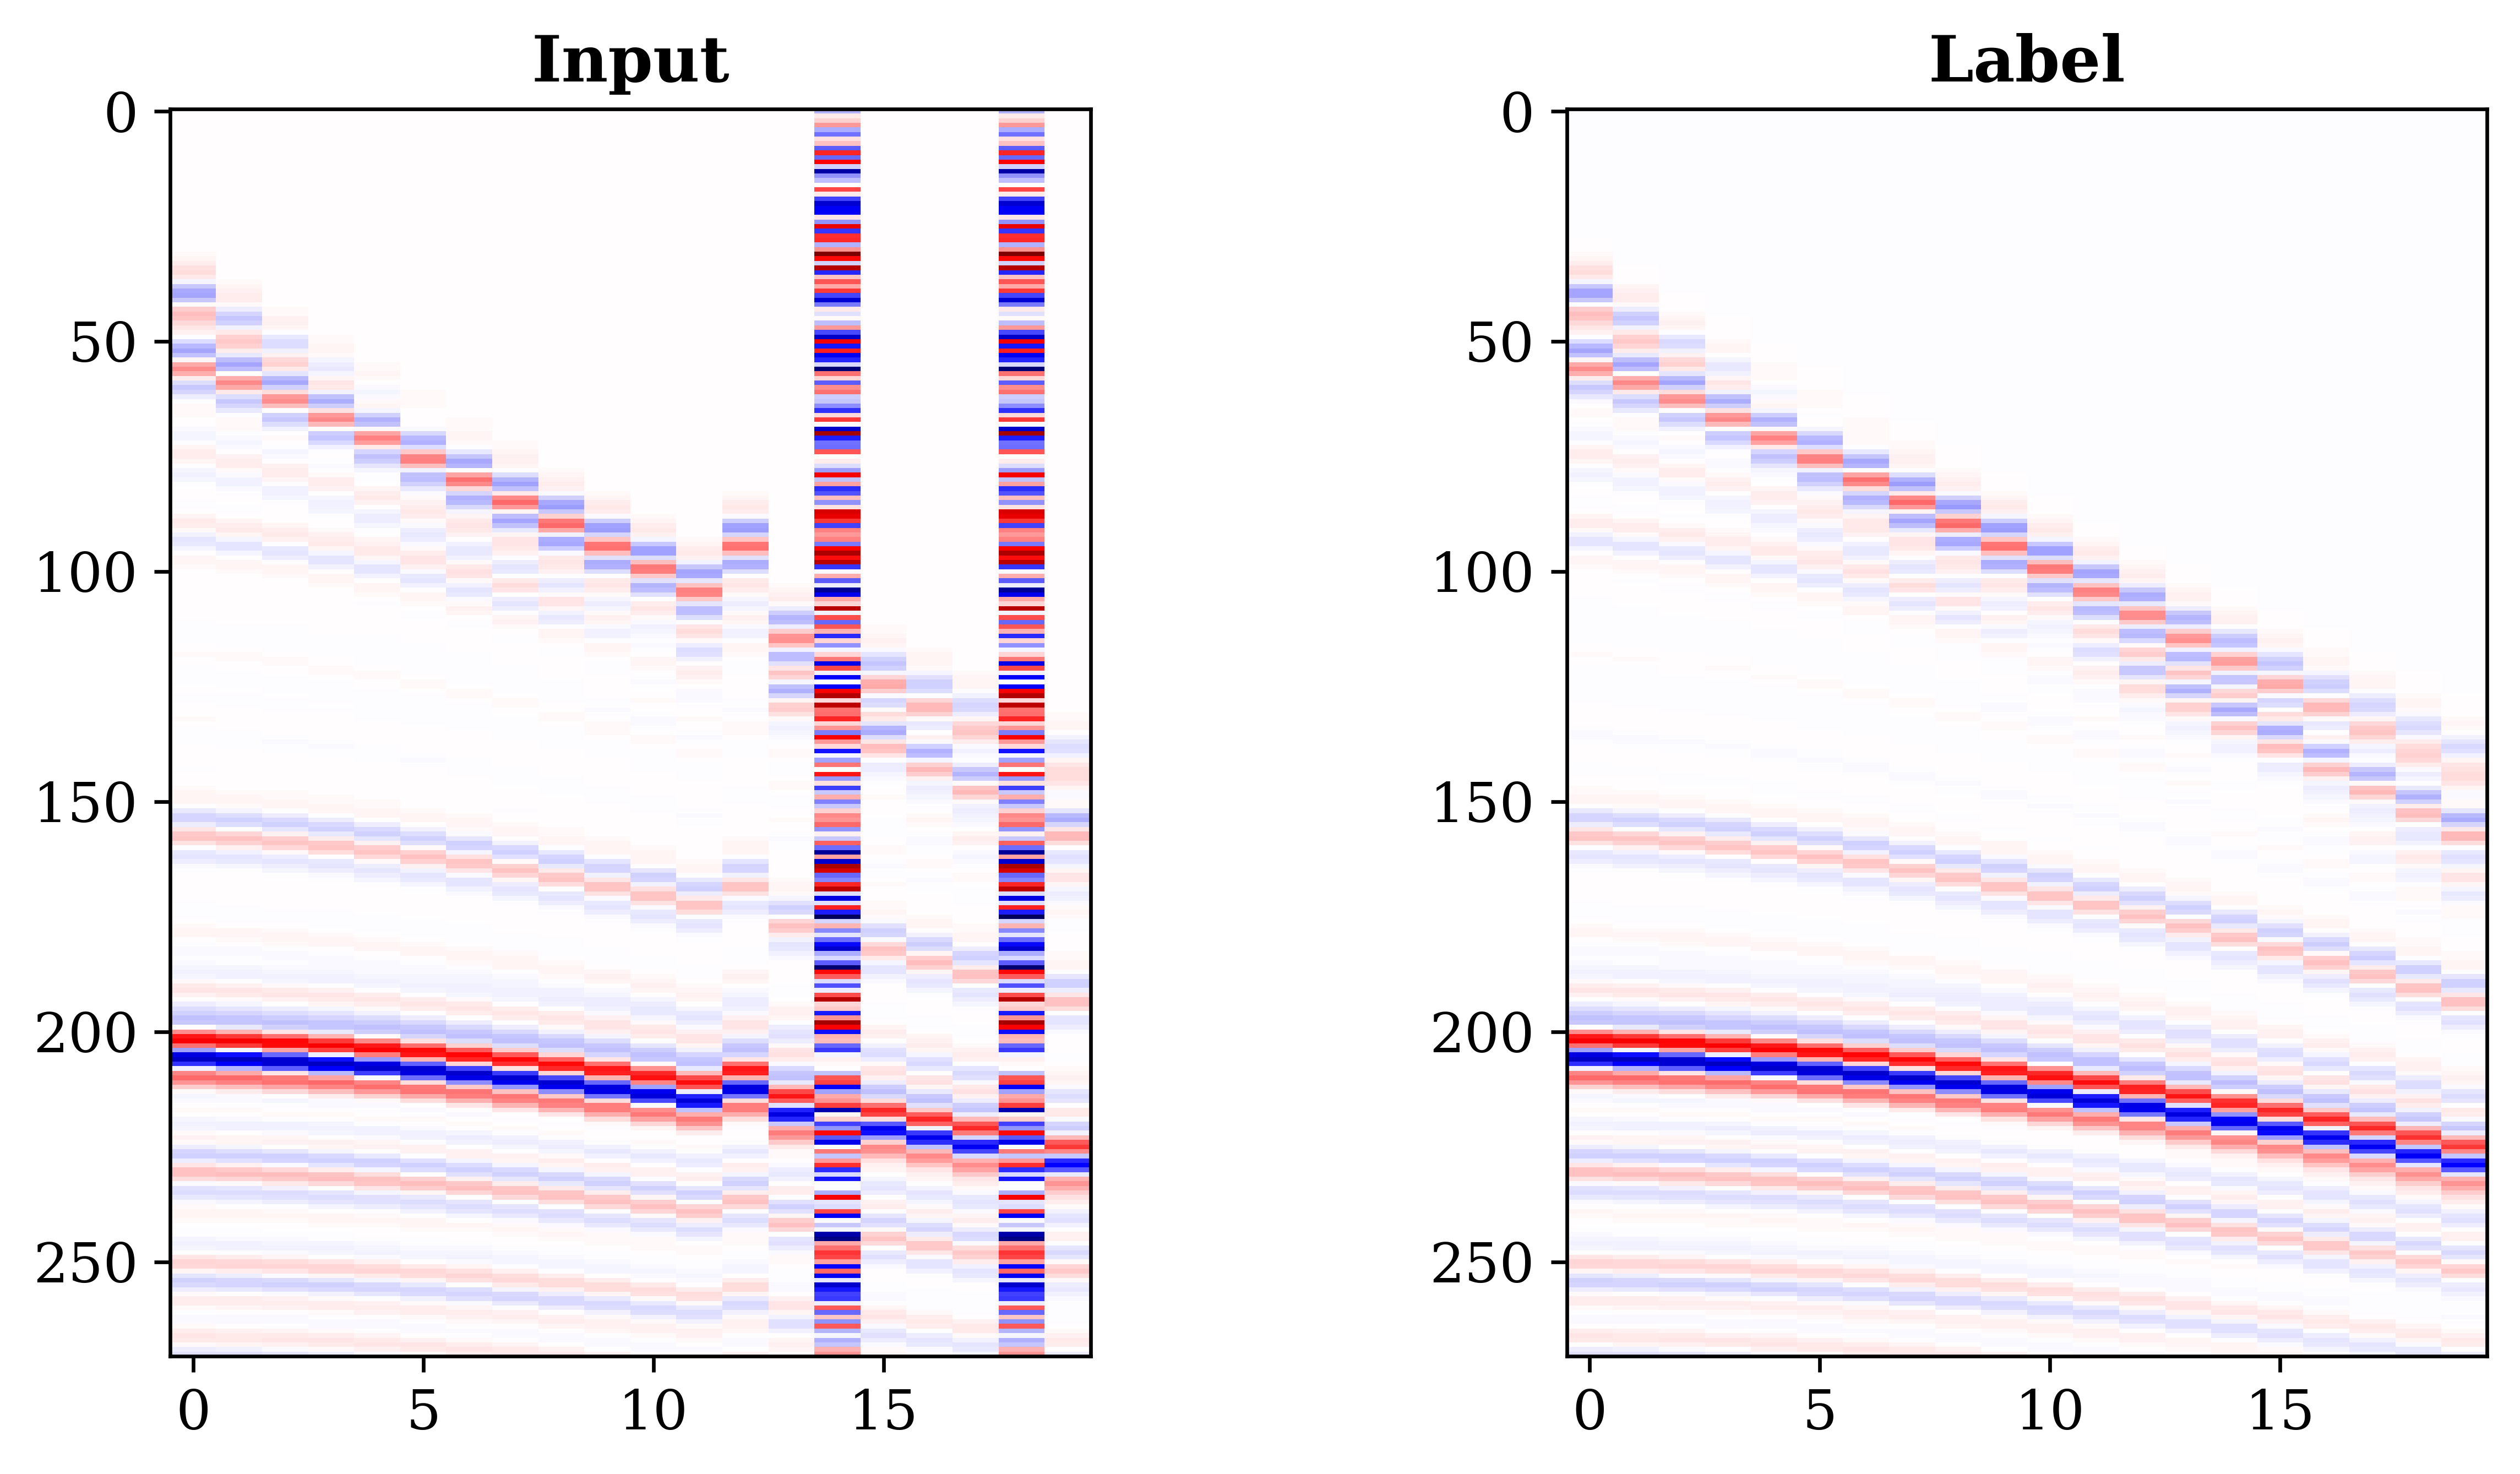

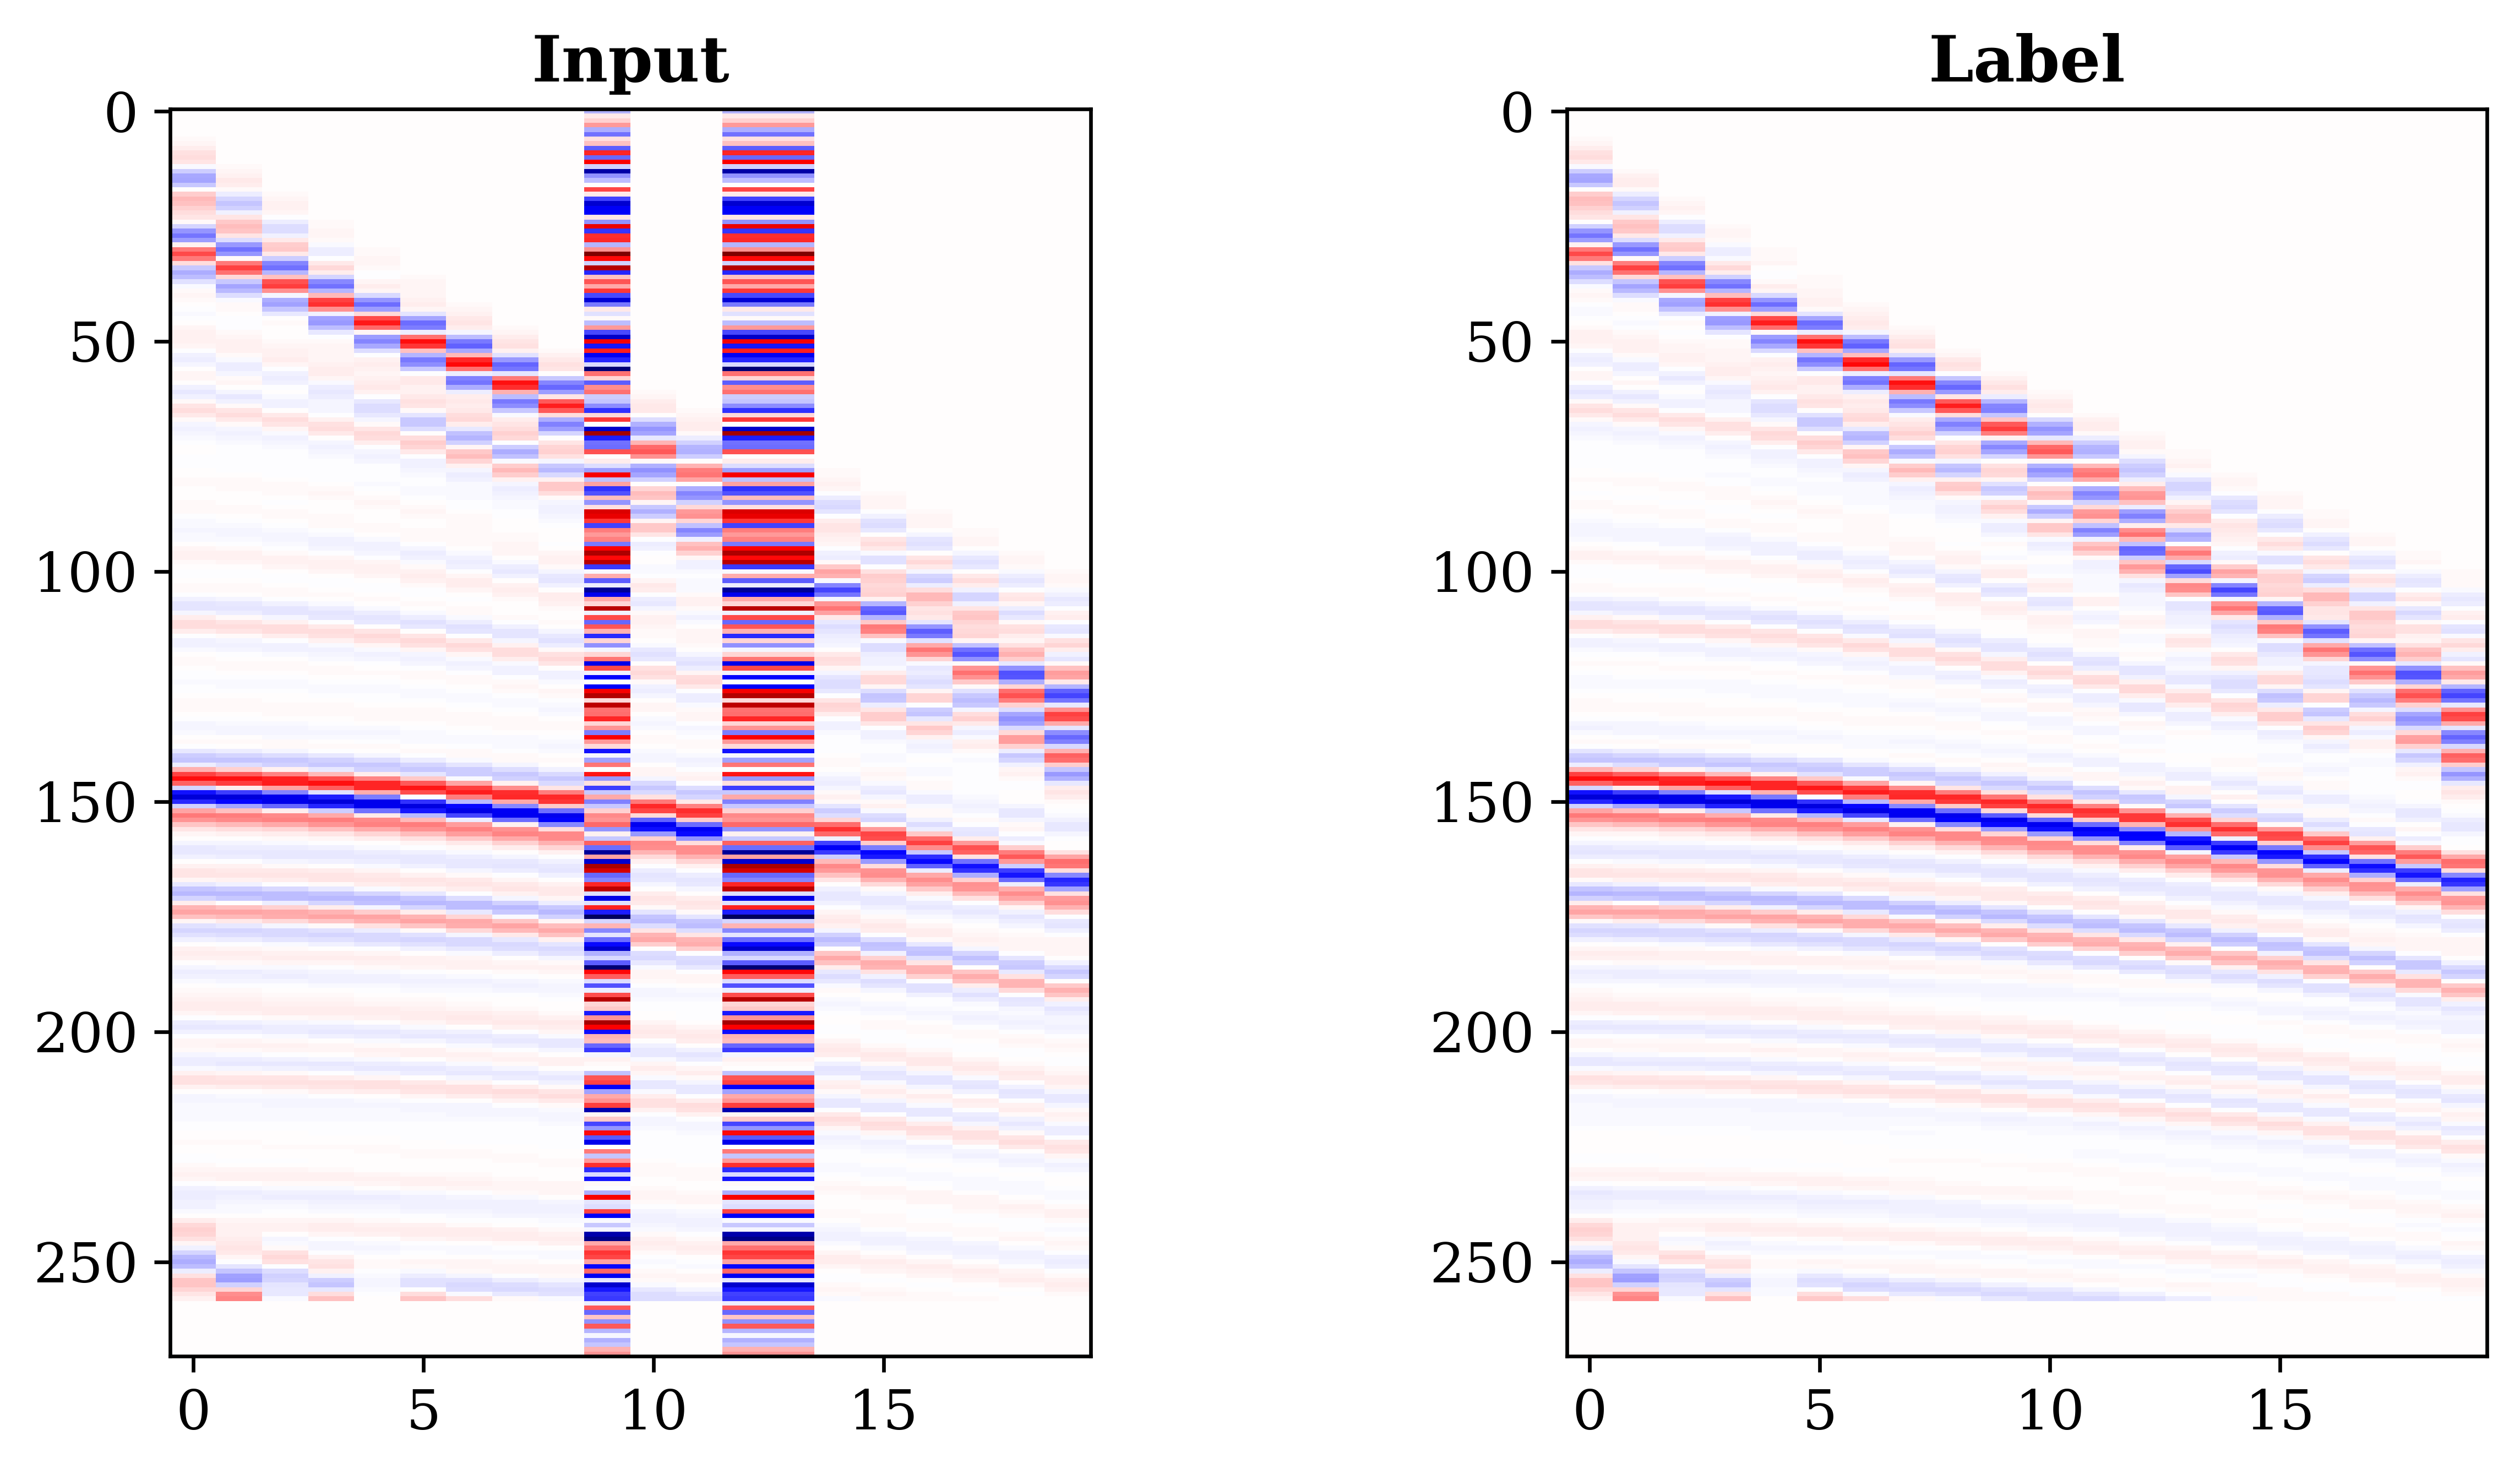

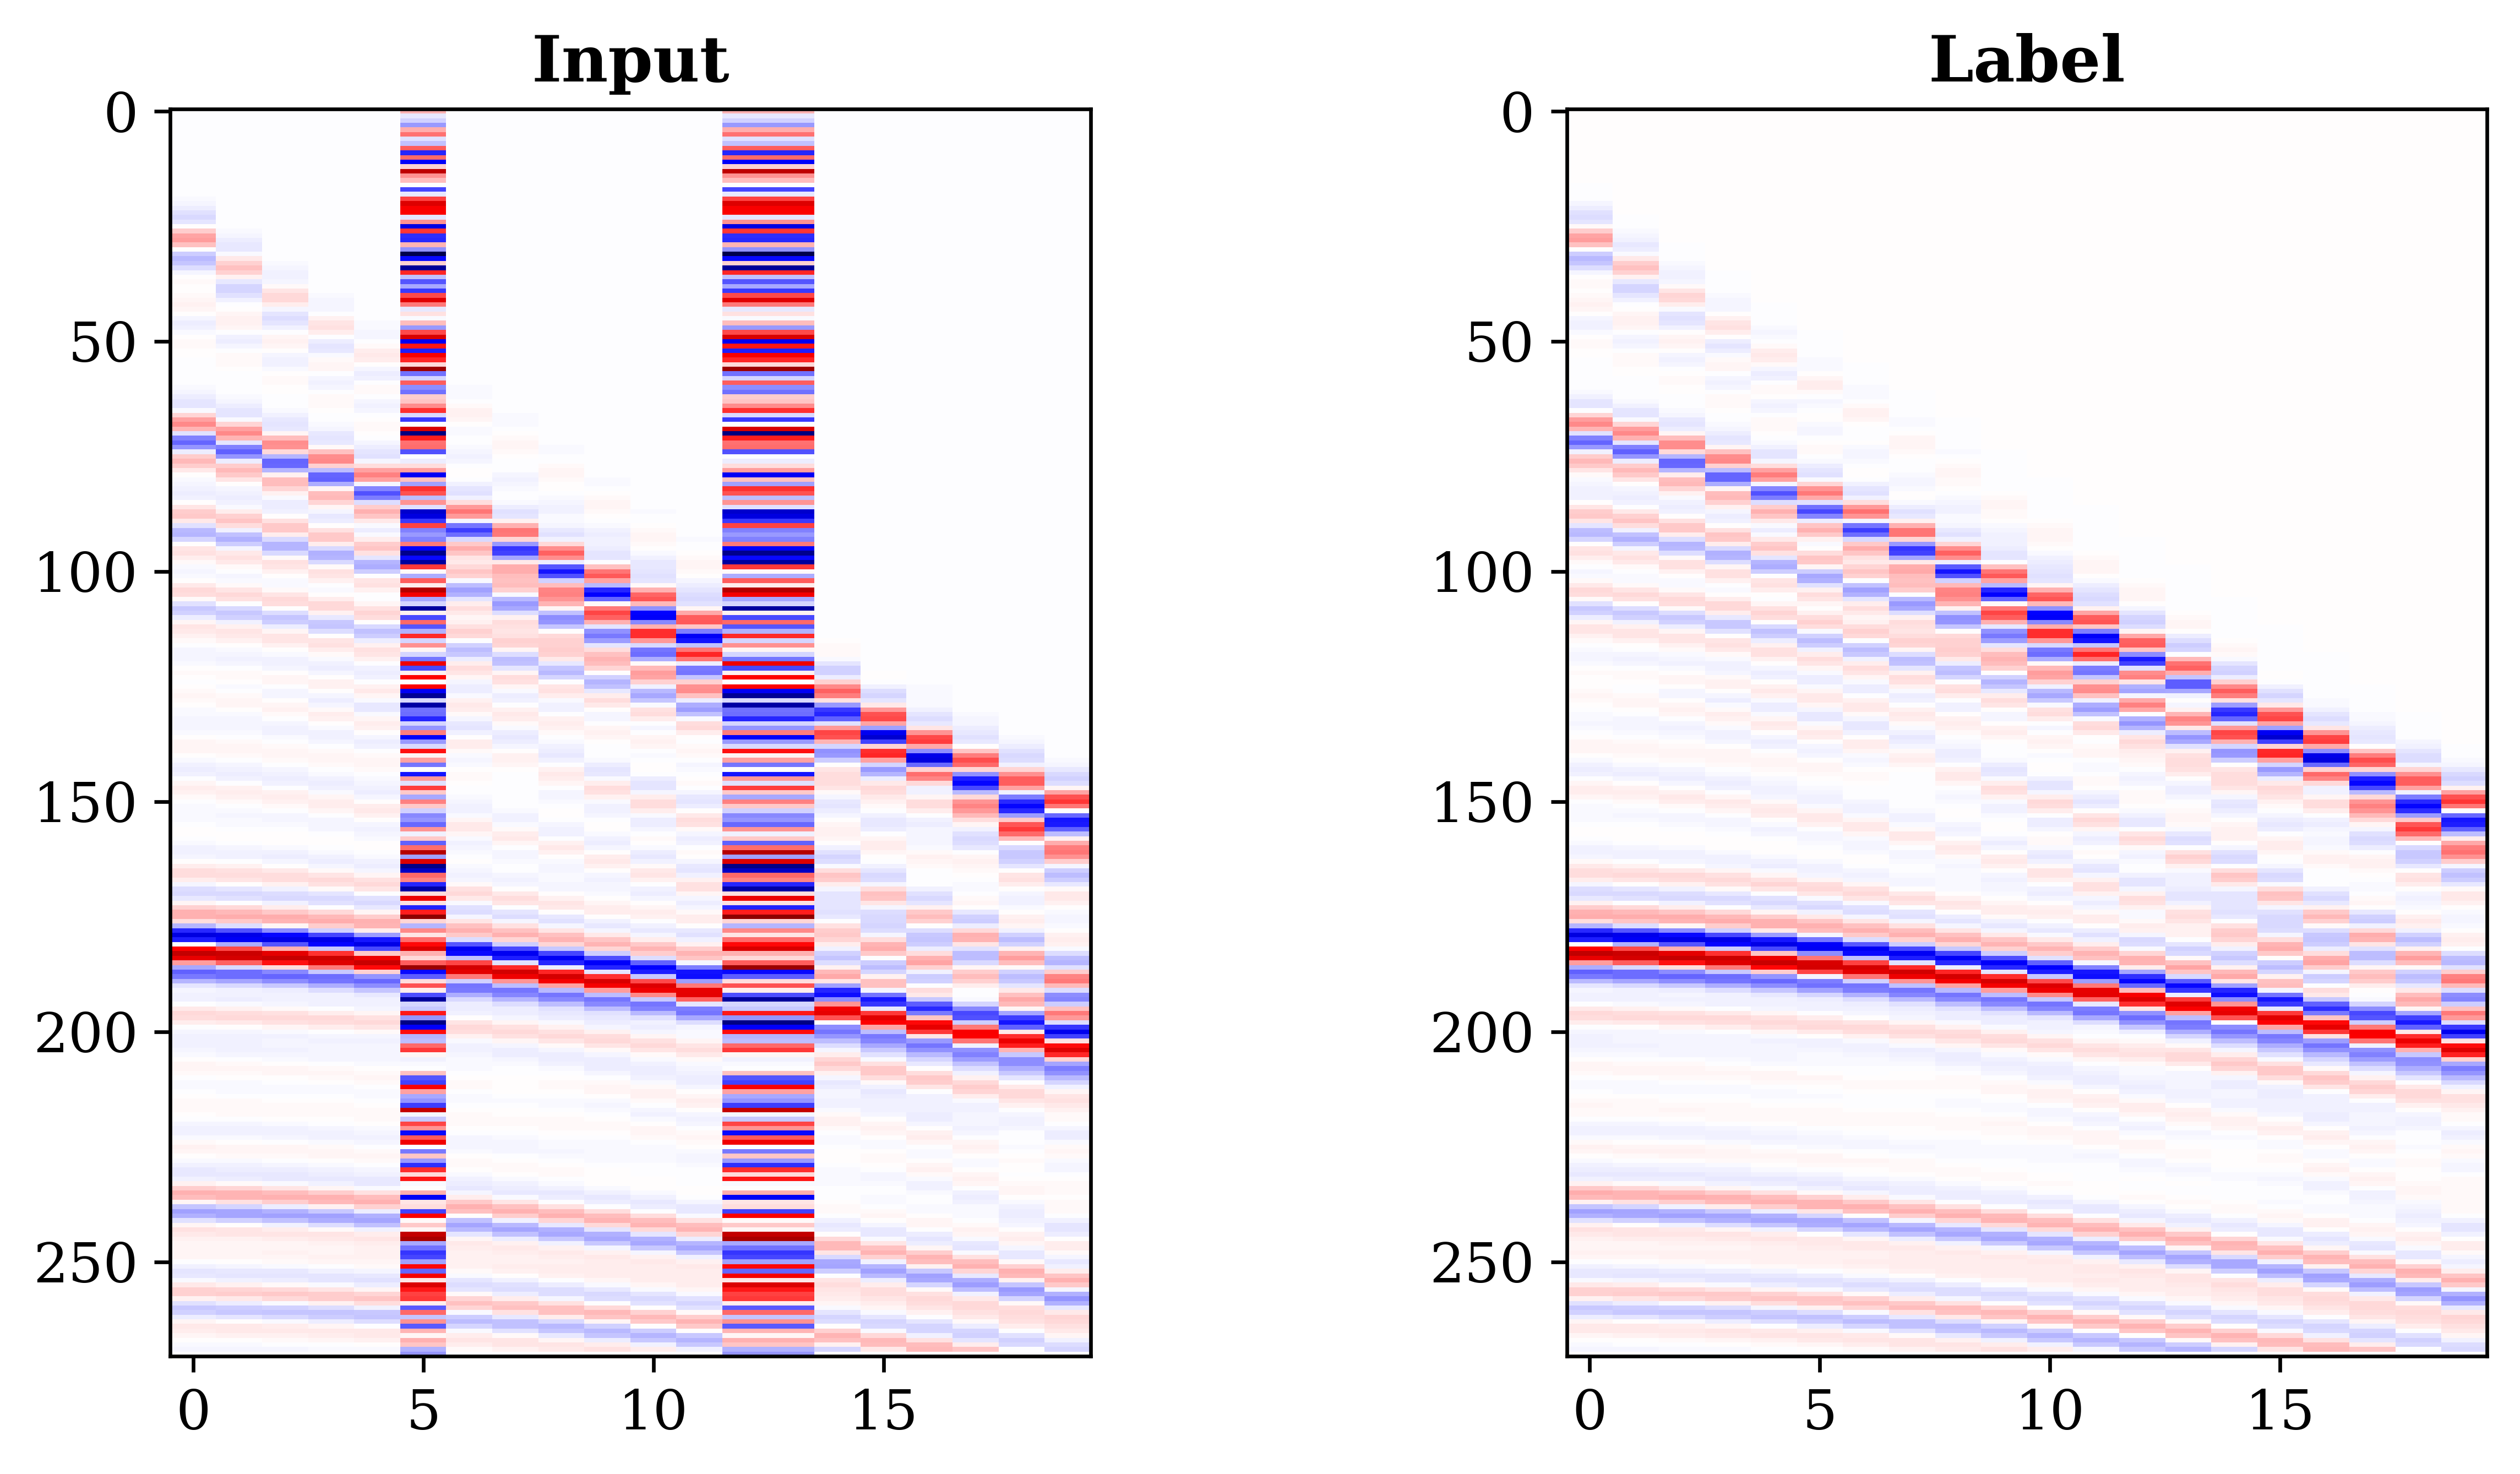

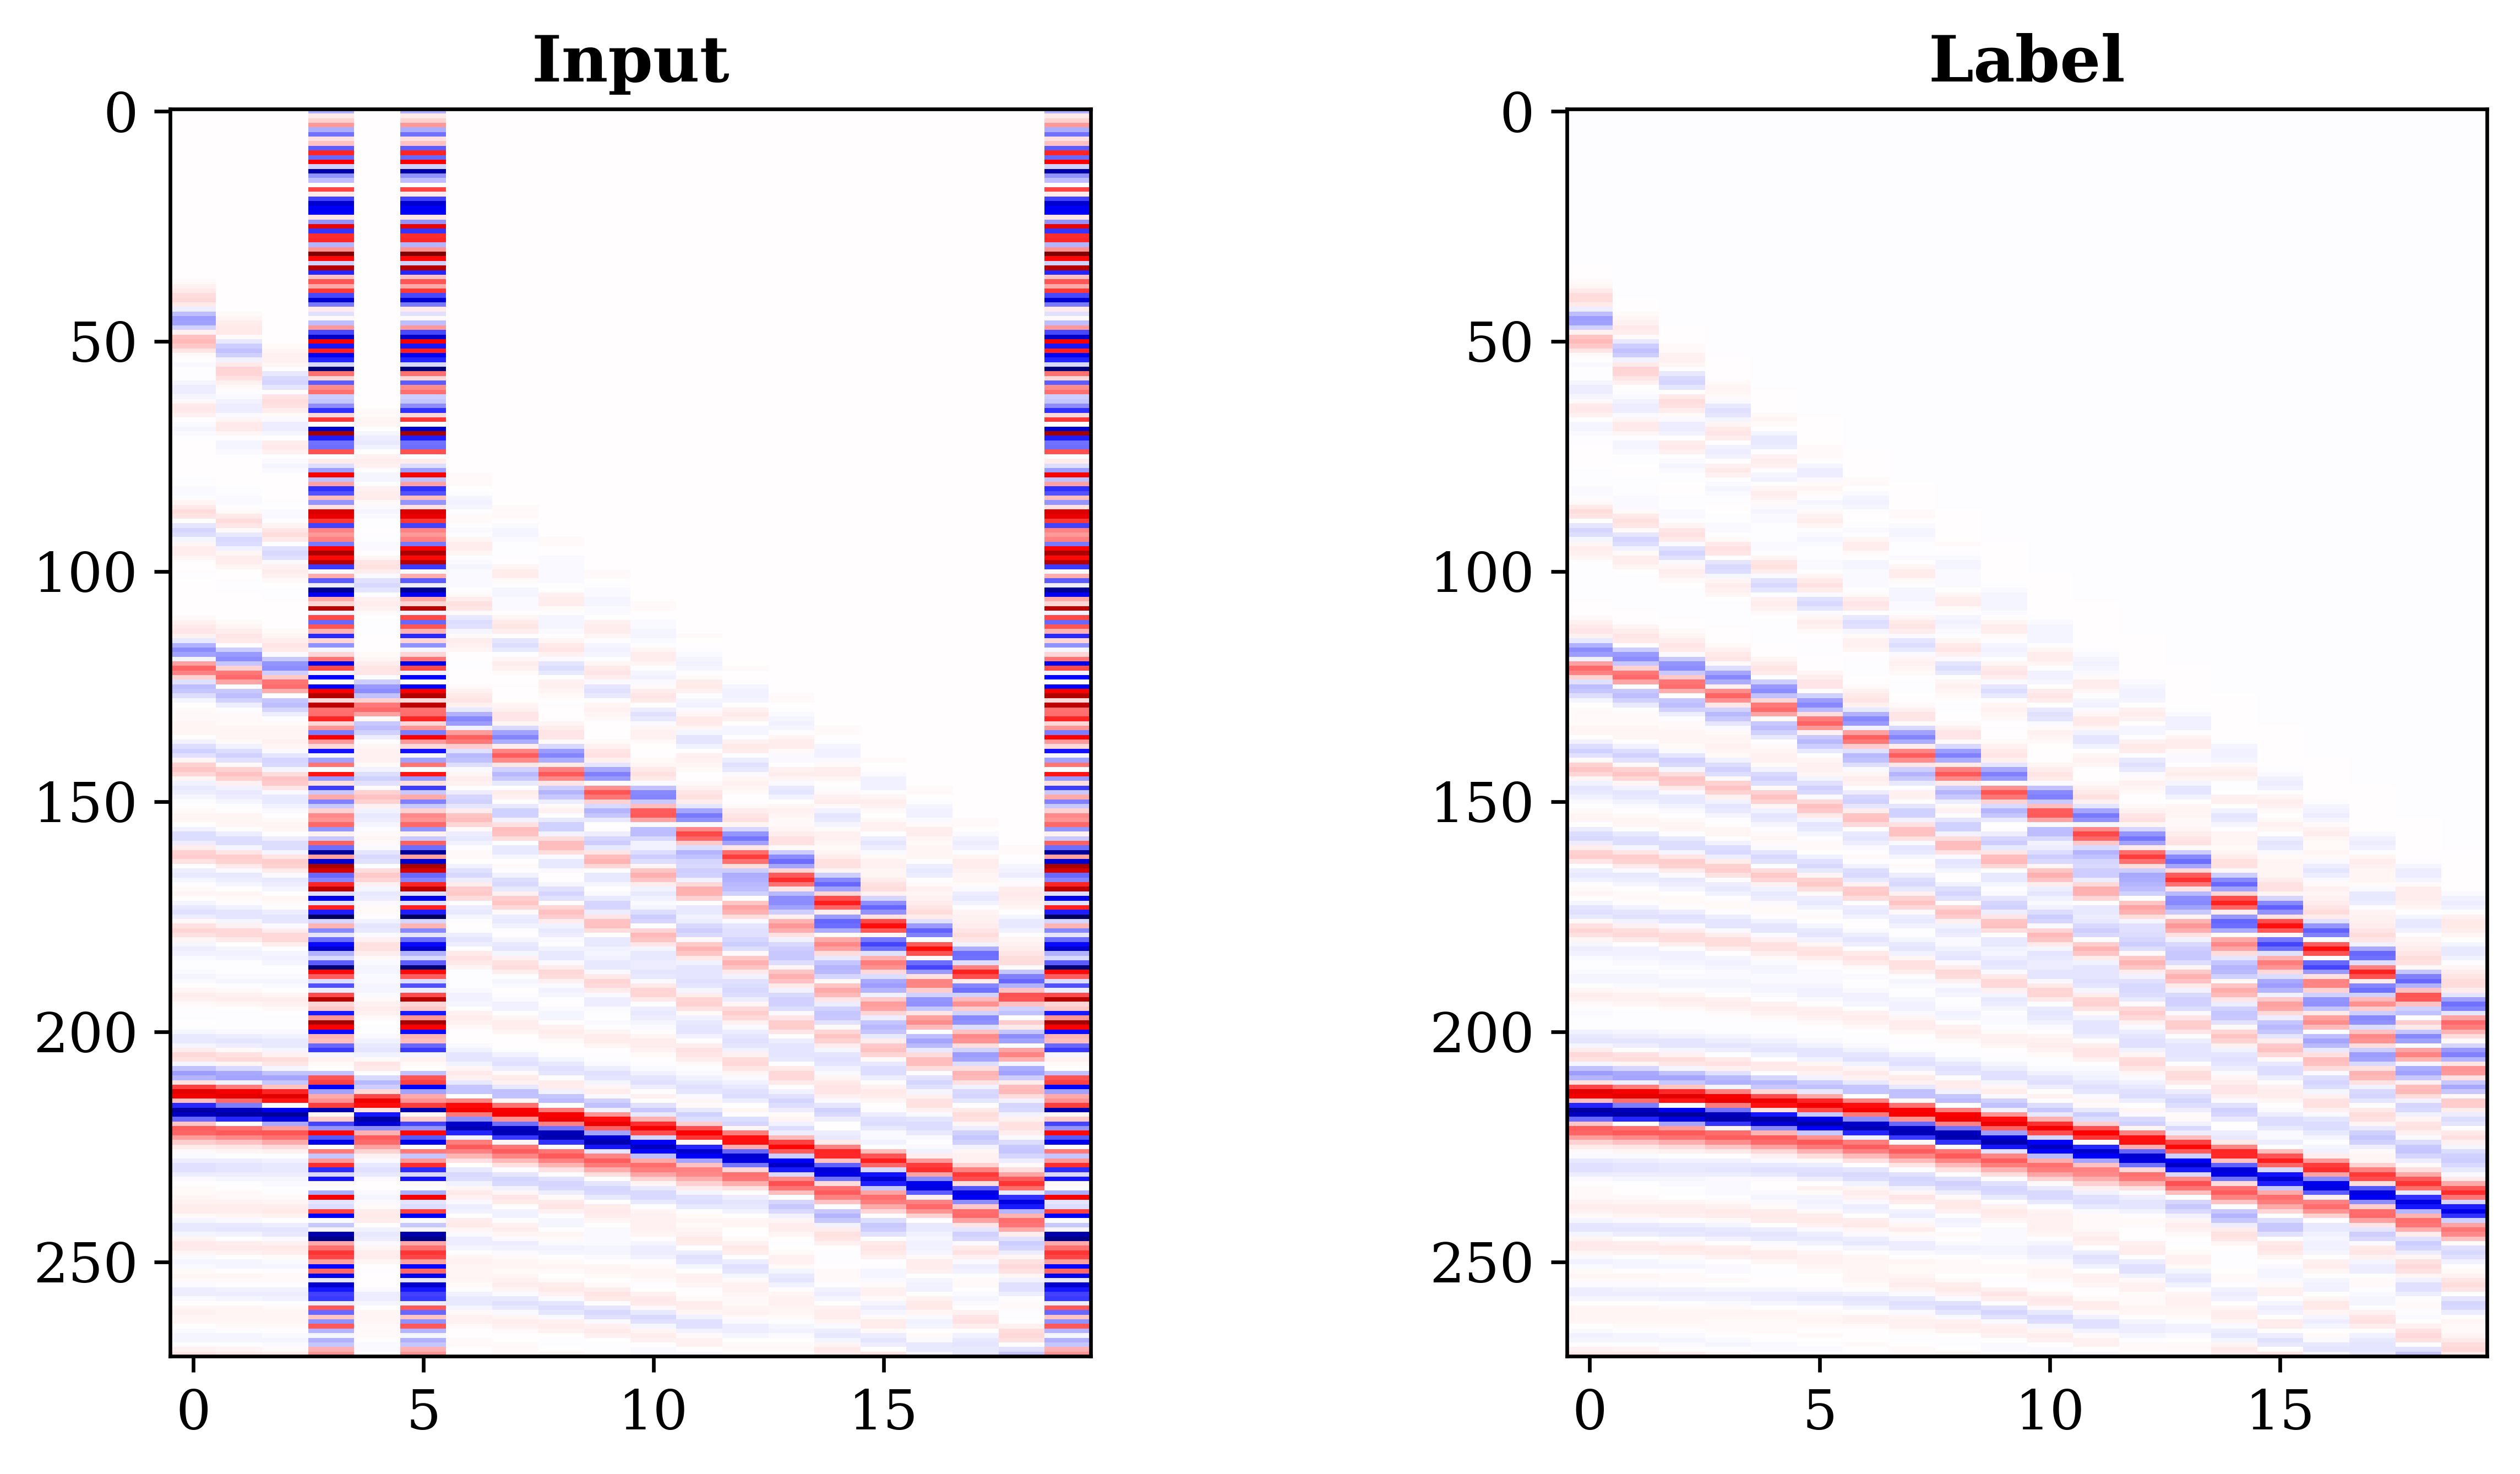

In [6]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #added

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].imshow(X['labels'][j, :, :].swapaxes(0, 1) - X['labels'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[1].set_title("Label")

## Setup StorSeismic pre-training model

In [7]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Swap built-in modules with the pre-defined ones

#### Swap the embedding and the prediction head

In [8]:
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead
transformers.models.bert.modeling_bert.BertSelfAttention = BertSelfAttention

#### Check existing starting model before changing other modules

In [9]:
starting_model_fn = ('_').join([str(config.hidden_size), str(config.num_hidden_layers), "startingmodel.pt"])
if not os.path.exists(os.path.join(config.parent_dir, "starting_model")):
    os.makedirs(os.path.join(config.parent_dir, "starting_model"))
if not os.path.exists(os.path.join(config.parent_dir, "starting_model", starting_model_fn)):
    model = BertForMaskedLM(config)
    torch.save(model, os.path.join(config.parent_dir, "starting_model", starting_model_fn))

#### Swap with Pre-LN or Post-LN

We will use Pre-LN BERT instead of Post-LN BERT, which is more insensitive to hyperparameter tuning (Xiong et al., 2020).

In [10]:
if config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

### Instantiate model

In [11]:
model = BertForMaskedLM(config)

#### Load weights from starting model (to preserve starting point on every run)

In [12]:
model_state_dict = model.state_dict()
if config.pre_ln:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn))
    layernorm_key_a = [k for k in starting_model.state_dict().keys() if 'LayerNorm' in k]
    layernorm_key_b = [k for k in model.state_dict().keys() if 'LayerNorm' in k]
    for key in starting_model.state_dict().keys():
        if 'LayerNorm' not in key:
            model_state_dict[key] = starting_model.state_dict()[key]

    for key_a, key_b in zip(layernorm_key_a, layernorm_key_b):
        model_state_dict[key_b] = starting_model.state_dict()[key_a]

    model.load_state_dict(model_state_dict)
else:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn))
    model.load_state_dict(starting_model.state_dict())

#### Check number of trainable parameters

In [13]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

In [14]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.word_embeddings.bias,256
2,bert.embeddings.LayerNorm.weight,256
3,bert.embeddings.LayerNorm.bias,256
4,bert.encoder.layer.0.attention.LayerNorm.weight,256
5,bert.encoder.layer.0.attention.LayerNorm.bias,256
6,bert.encoder.layer.0.attention.self.query.weight,65536
7,bert.encoder.layer.0.attention.self.query.bias,256
8,bert.encoder.layer.0.attention.self.key.weight,65536
9,bert.encoder.layer.0.attention.self.key.bias,256


Total Trainable Params: 3298831


3298831

In [13]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

^C


In [15]:
#!conda install -c anaconda cudatoolkit
import torch
  
print(f"Is CUDA supported by this system {torch.cuda.is_available()}")
print( f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2060


In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:25:35_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


In [14]:
!nvidia-smi

Wed Feb  1 00:00:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8     8W /  N/A |    700MiB /  6144MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# get index of currently selected device
torch.cuda.current_device() # returns 0 in my case


# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case


# get the name of the device
torch.cuda.get_device_name(0) # good old Tesla K80


'NVIDIA GeForce RTX 2060'

#### Send model to device

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cuda')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [18]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.MSELoss(reduction='mean')

# Number of epochs
epochs = config.epoch

### Train

<IPython.core.display.Javascript object>


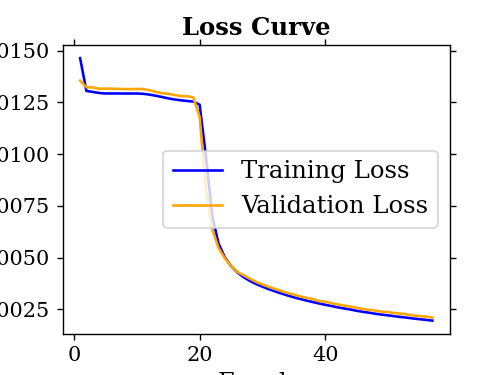

In [19]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

In [20]:
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_pretraining(model, optim, loss_fn, train_dataloader, test_dataloader, epochs, device, 
                tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)

%matplotlib inline
plt.ioff()

  0%|          | 0/141 [00:00<?, ?it/s]C:\Users\diego\anaconda3\envs\env1_cloned_tf\lib\site-packages\radam\radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1420.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|██████████| 36/36 [00:03<00:00,  9.49it/s, loss=0.00144]


Epoch time: 38.51 s
Total time elapsed: 38.51 s
---------------------------------------
Validation loss decreased (inf --> 0.001355).  Saving model ...


Validation 1: 100%|██████████| 36/36 [00:03<00:00,  9.57it/s, loss=0.00132]


Epoch time: 34.73 s
Total time elapsed: 73.45 s
---------------------------------------
Validation loss decreased (0.001355 --> 0.001324).  Saving model ...


Validation 2: 100%|██████████| 36/36 [00:03<00:00, 10.16it/s, loss=0.0014] 


Epoch time: 33.42 s
Total time elapsed: 107.17 s
---------------------------------------
Validation loss decreased (0.001324 --> 0.001322).  Saving model ...


Validation 3: 100%|██████████| 36/36 [00:03<00:00,  9.51it/s, loss=0.0013] 


Epoch time: 32.93 s
Total time elapsed: 140.23 s
---------------------------------------
Validation loss decreased (0.001322 --> 0.001316).  Saving model ...


Validation 4: 100%|██████████| 36/36 [00:03<00:00,  9.57it/s, loss=0.00135]


Epoch time: 33.54 s
Total time elapsed: 173.90 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 5: 100%|██████████| 36/36 [00:03<00:00,  9.10it/s, loss=0.00133]


Epoch time: 34.73 s
Total time elapsed: 208.72 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 6: 100%|██████████| 36/36 [00:03<00:00,  9.50it/s, loss=0.00129]


Epoch time: 33.50 s
Total time elapsed: 242.42 s
---------------------------------------
Validation loss decreased (0.001316 --> 0.001316).  Saving model ...


Validation 7: 100%|██████████| 36/36 [00:03<00:00,  9.34it/s, loss=0.00127]


Epoch time: 33.63 s
Total time elapsed: 276.19 s
---------------------------------------
Validation loss decreased (0.001316 --> 0.001315).  Saving model ...


Validation 8: 100%|██████████| 36/36 [00:03<00:00,  9.16it/s, loss=0.00126]


Epoch time: 33.93 s
Total time elapsed: 310.31 s
---------------------------------------
Validation loss decreased (0.001315 --> 0.001314).  Saving model ...


Validation 9: 100%|██████████| 36/36 [00:03<00:00,  9.65it/s, loss=0.0013] 


Epoch time: 33.55 s
Total time elapsed: 344.01 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 10: 100%|██████████| 36/36 [00:01<00:00, 27.23it/s, loss=0.00143]


Epoch time: 15.35 s
Total time elapsed: 359.43 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 11: 100%|██████████| 36/36 [00:01<00:00, 25.58it/s, loss=0.00136]


Epoch time: 10.58 s
Total time elapsed: 370.08 s
---------------------------------------
Validation loss decreased (0.001314 --> 0.001309).  Saving model ...


Validation 12: 100%|██████████| 36/36 [00:01<00:00, 24.64it/s, loss=0.00127]


Epoch time: 10.67 s
Total time elapsed: 380.84 s
---------------------------------------
Validation loss decreased (0.001309 --> 0.001301).  Saving model ...


Validation 13: 100%|██████████| 36/36 [00:01<00:00, 26.92it/s, loss=0.00127]


Epoch time: 10.81 s
Total time elapsed: 391.76 s
---------------------------------------
Validation loss decreased (0.001301 --> 0.001295).  Saving model ...


Validation 14: 100%|██████████| 36/36 [00:01<00:00, 28.46it/s, loss=0.00129]


Epoch time: 10.22 s
Total time elapsed: 402.05 s
---------------------------------------
Validation loss decreased (0.001295 --> 0.001292).  Saving model ...


Validation 15: 100%|██████████| 36/36 [00:01<00:00, 29.05it/s, loss=0.00129]


Epoch time: 10.29 s
Total time elapsed: 412.42 s
---------------------------------------
Validation loss decreased (0.001292 --> 0.001286).  Saving model ...


Validation 16: 100%|██████████| 36/36 [00:01<00:00, 29.95it/s, loss=0.00121]


Epoch time: 10.13 s
Total time elapsed: 422.63 s
---------------------------------------
Validation loss decreased (0.001286 --> 0.001281).  Saving model ...


Validation 17: 100%|██████████| 36/36 [00:01<00:00, 26.43it/s, loss=0.00131]


Epoch time: 10.35 s
Total time elapsed: 433.06 s
---------------------------------------
Validation loss decreased (0.001281 --> 0.001280).  Saving model ...


Validation 18: 100%|██████████| 36/36 [00:01<00:00, 28.80it/s, loss=0.0012] 


Epoch time: 10.09 s
Total time elapsed: 443.23 s
---------------------------------------
Validation loss decreased (0.001280 --> 0.001275).  Saving model ...


Validation 19: 100%|██████████| 36/36 [00:01<00:00, 32.00it/s, loss=0.00114]


Epoch time: 9.69 s
Total time elapsed: 453.01 s
---------------------------------------
Validation loss decreased (0.001275 --> 0.001180).  Saving model ...


Validation 20: 100%|██████████| 36/36 [00:01<00:00, 32.00it/s, loss=0.000835]


Epoch time: 9.80 s
Total time elapsed: 462.88 s
---------------------------------------
Validation loss decreased (0.001180 --> 0.000832).  Saving model ...


Validation 21: 100%|██████████| 36/36 [00:01<00:00, 32.00it/s, loss=0.000781]


Epoch time: 9.76 s
Total time elapsed: 472.72 s
---------------------------------------
Validation loss decreased (0.000832 --> 0.000639).  Saving model ...


Validation 22: 100%|██████████| 36/36 [00:01<00:00, 31.56it/s, loss=0.000525]


Epoch time: 9.80 s
Total time elapsed: 482.60 s
---------------------------------------
Validation loss decreased (0.000639 --> 0.000548).  Saving model ...


Validation 23: 100%|██████████| 36/36 [00:01<00:00, 30.05it/s, loss=0.000491]


Epoch time: 10.23 s
Total time elapsed: 492.90 s
---------------------------------------
Validation loss decreased (0.000548 --> 0.000497).  Saving model ...


Validation 24: 100%|██████████| 36/36 [00:01<00:00, 29.55it/s, loss=0.000444]


Epoch time: 10.17 s
Total time elapsed: 503.16 s
---------------------------------------
Validation loss decreased (0.000497 --> 0.000461).  Saving model ...


Validation 25: 100%|██████████| 36/36 [00:01<00:00, 29.60it/s, loss=0.000366]


Epoch time: 10.29 s
Total time elapsed: 513.55 s
---------------------------------------
Validation loss decreased (0.000461 --> 0.000431).  Saving model ...


Validation 26: 100%|██████████| 36/36 [00:01<00:00, 26.59it/s, loss=0.000378]


Epoch time: 10.22 s
Total time elapsed: 523.86 s
---------------------------------------
Validation loss decreased (0.000431 --> 0.000415).  Saving model ...


Validation 27: 100%|██████████| 36/36 [00:01<00:00, 31.56it/s, loss=0.000438]


Epoch time: 10.02 s
Total time elapsed: 533.99 s
---------------------------------------
Validation loss decreased (0.000415 --> 0.000398).  Saving model ...


Validation 28: 100%|██████████| 36/36 [00:01<00:00, 30.73it/s, loss=0.000356]


Epoch time: 10.37 s
Total time elapsed: 544.46 s
---------------------------------------
Validation loss decreased (0.000398 --> 0.000383).  Saving model ...


Validation 29: 100%|██████████| 36/36 [00:01<00:00, 29.95it/s, loss=0.000346]


Epoch time: 10.28 s
Total time elapsed: 554.82 s
---------------------------------------
Validation loss decreased (0.000383 --> 0.000371).  Saving model ...


Validation 30: 100%|██████████| 36/36 [00:01<00:00, 30.58it/s, loss=0.000333]


Epoch time: 10.21 s
Total time elapsed: 565.11 s
---------------------------------------
Validation loss decreased (0.000371 --> 0.000359).  Saving model ...


Validation 31: 100%|██████████| 36/36 [00:01<00:00, 30.28it/s, loss=0.000352]


Epoch time: 10.23 s
Total time elapsed: 575.43 s
---------------------------------------
Validation loss decreased (0.000359 --> 0.000349).  Saving model ...


Validation 32: 100%|██████████| 36/36 [00:01<00:00, 30.02it/s, loss=0.000306]


Epoch time: 10.29 s
Total time elapsed: 585.80 s
---------------------------------------
Validation loss decreased (0.000349 --> 0.000339).  Saving model ...


Validation 33: 100%|██████████| 36/36 [00:01<00:00, 30.16it/s, loss=0.000306]


Epoch time: 10.15 s
Total time elapsed: 596.03 s
---------------------------------------
Validation loss decreased (0.000339 --> 0.000330).  Saving model ...


Validation 34: 100%|██████████| 36/36 [00:01<00:00, 29.46it/s, loss=0.000314]


Epoch time: 10.28 s
Total time elapsed: 606.38 s
---------------------------------------
Validation loss decreased (0.000330 --> 0.000321).  Saving model ...


Validation 35: 100%|██████████| 36/36 [00:01<00:00, 25.17it/s, loss=0.000322]


Epoch time: 10.31 s
Total time elapsed: 616.78 s
---------------------------------------
Validation loss decreased (0.000321 --> 0.000313).  Saving model ...


Validation 36: 100%|██████████| 36/36 [00:01<00:00, 29.27it/s, loss=0.00031] 


Epoch time: 10.11 s
Total time elapsed: 626.99 s
---------------------------------------
Validation loss decreased (0.000313 --> 0.000306).  Saving model ...


Validation 37: 100%|██████████| 36/36 [00:01<00:00, 29.90it/s, loss=0.000371]


Epoch time: 10.17 s
Total time elapsed: 637.27 s
---------------------------------------
Validation loss decreased (0.000306 --> 0.000301).  Saving model ...


Validation 38: 100%|██████████| 36/36 [00:01<00:00, 28.74it/s, loss=0.000291]


Epoch time: 10.22 s
Total time elapsed: 647.57 s
---------------------------------------
Validation loss decreased (0.000301 --> 0.000291).  Saving model ...


Validation 39: 100%|██████████| 36/36 [00:01<00:00, 29.65it/s, loss=0.000307]


Epoch time: 10.21 s
Total time elapsed: 657.87 s
---------------------------------------
Validation loss decreased (0.000291 --> 0.000288).  Saving model ...


Validation 40: 100%|██████████| 36/36 [00:01<00:00, 29.28it/s, loss=0.000274]


Epoch time: 10.20 s
Total time elapsed: 668.16 s
---------------------------------------
Validation loss decreased (0.000288 --> 0.000280).  Saving model ...


Validation 41: 100%|██████████| 36/36 [00:01<00:00, 29.79it/s, loss=0.000238]


Epoch time: 10.24 s
Total time elapsed: 678.48 s
---------------------------------------
Validation loss decreased (0.000280 --> 0.000274).  Saving model ...


Validation 42: 100%|██████████| 36/36 [00:01<00:00, 30.05it/s, loss=0.000225]


Epoch time: 10.22 s
Total time elapsed: 688.78 s
---------------------------------------
Validation loss decreased (0.000274 --> 0.000268).  Saving model ...


Validation 43: 100%|██████████| 36/36 [00:01<00:00, 29.96it/s, loss=0.000321]


Epoch time: 10.22 s
Total time elapsed: 699.08 s
---------------------------------------
Validation loss decreased (0.000268 --> 0.000264).  Saving model ...


Validation 44: 100%|██████████| 36/36 [00:01<00:00, 26.89it/s, loss=0.00025] 


Epoch time: 10.24 s
Total time elapsed: 709.40 s
---------------------------------------
Validation loss decreased (0.000264 --> 0.000258).  Saving model ...


Validation 45: 100%|██████████| 36/36 [00:01<00:00, 27.29it/s, loss=0.000218]


Epoch time: 10.20 s
Total time elapsed: 719.68 s
---------------------------------------
Validation loss decreased (0.000258 --> 0.000252).  Saving model ...


Validation 46: 100%|██████████| 36/36 [00:01<00:00, 29.83it/s, loss=0.000266]


Epoch time: 10.18 s
Total time elapsed: 729.97 s
---------------------------------------
Validation loss decreased (0.000252 --> 0.000248).  Saving model ...


Validation 47: 100%|██████████| 36/36 [00:01<00:00, 29.47it/s, loss=0.000254]


Epoch time: 10.23 s
Total time elapsed: 740.29 s
---------------------------------------
Validation loss decreased (0.000248 --> 0.000244).  Saving model ...


Validation 48: 100%|██████████| 36/36 [00:01<00:00, 30.08it/s, loss=0.000236]


Epoch time: 10.31 s
Total time elapsed: 750.67 s
---------------------------------------
Validation loss decreased (0.000244 --> 0.000240).  Saving model ...


Validation 49: 100%|██████████| 36/36 [00:01<00:00, 30.06it/s, loss=0.000275]


Epoch time: 10.19 s
Total time elapsed: 760.95 s
---------------------------------------
Validation loss decreased (0.000240 --> 0.000238).  Saving model ...


Validation 50: 100%|██████████| 36/36 [00:01<00:00, 30.08it/s, loss=0.000231]


Epoch time: 10.18 s
Total time elapsed: 771.21 s
---------------------------------------
Validation loss decreased (0.000238 --> 0.000233).  Saving model ...


Validation 51: 100%|██████████| 36/36 [00:01<00:00, 29.97it/s, loss=0.00026] 


Epoch time: 10.22 s
Total time elapsed: 781.52 s
---------------------------------------
Validation loss decreased (0.000233 --> 0.000230).  Saving model ...


Validation 52: 100%|██████████| 36/36 [00:01<00:00, 28.95it/s, loss=0.000218]


Epoch time: 10.25 s
Total time elapsed: 791.85 s
---------------------------------------
Validation loss decreased (0.000230 --> 0.000226).  Saving model ...


Validation 53: 100%|██████████| 36/36 [00:01<00:00, 28.67it/s, loss=0.000189]


Epoch time: 10.28 s
Total time elapsed: 802.21 s
---------------------------------------
Validation loss decreased (0.000226 --> 0.000221).  Saving model ...


Validation 54: 100%|██████████| 36/36 [00:01<00:00, 26.11it/s, loss=0.000191]


Epoch time: 10.26 s
Total time elapsed: 812.55 s
---------------------------------------
Validation loss decreased (0.000221 --> 0.000218).  Saving model ...


Validation 55: 100%|██████████| 36/36 [00:01<00:00, 29.67it/s, loss=0.000216]


Epoch time: 10.20 s
Total time elapsed: 822.87 s
---------------------------------------
Validation loss decreased (0.000218 --> 0.000215).  Saving model ...


Validation 56: 100%|██████████| 36/36 [00:01<00:00, 29.44it/s, loss=0.000212]


Epoch time: 10.43 s
Total time elapsed: 833.42 s
---------------------------------------
Validation loss decreased (0.000215 --> 0.000211).  Saving model ...


Epoch 57:  24%|██▍       | 34/141 [00:02<00:07, 14.57it/s, loss=0.000172]


KeyboardInterrupt: 

### Plot results

tensor([4032, 6949, 2042, 2387])


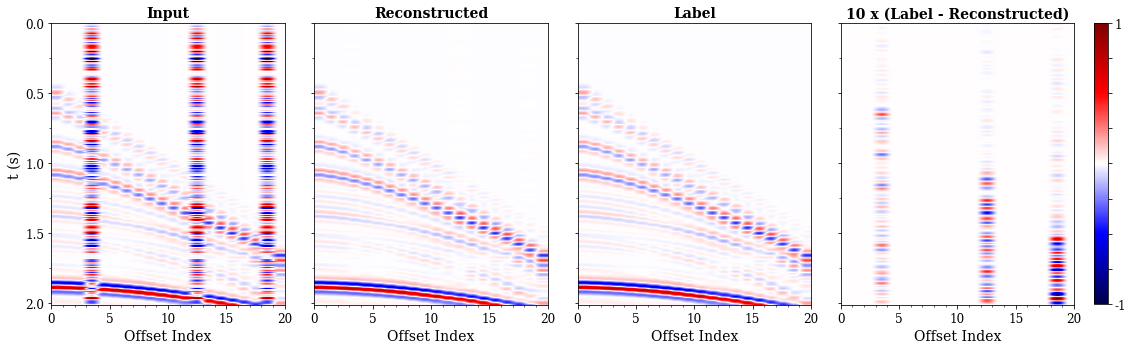

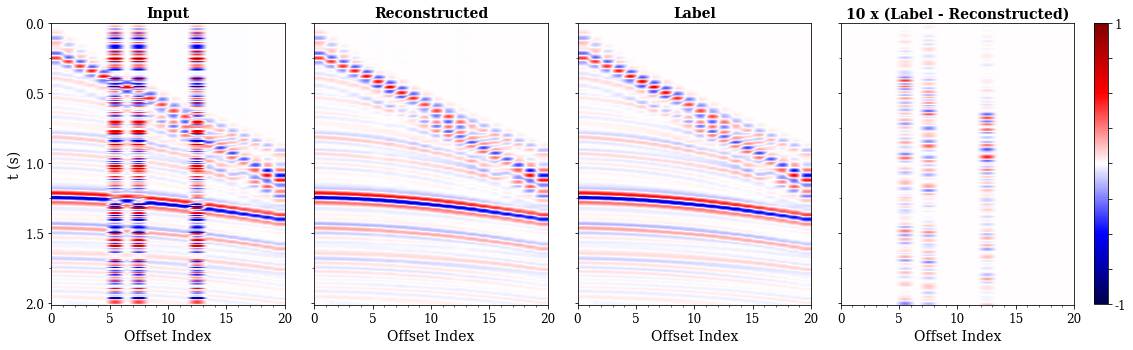

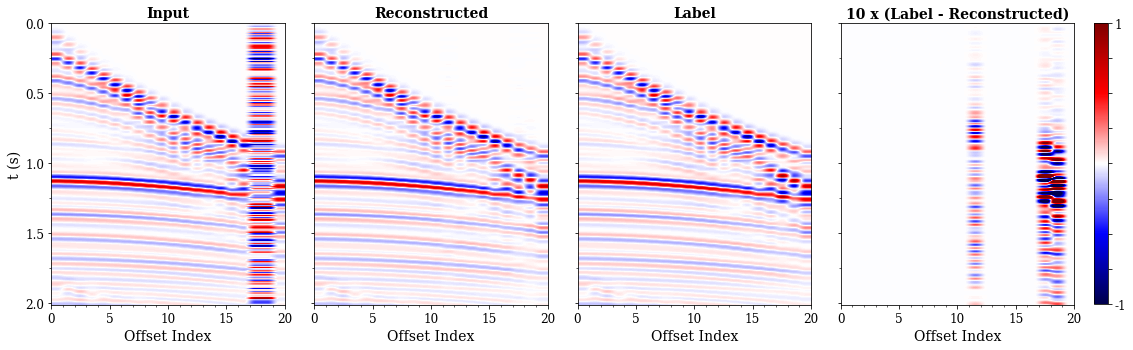

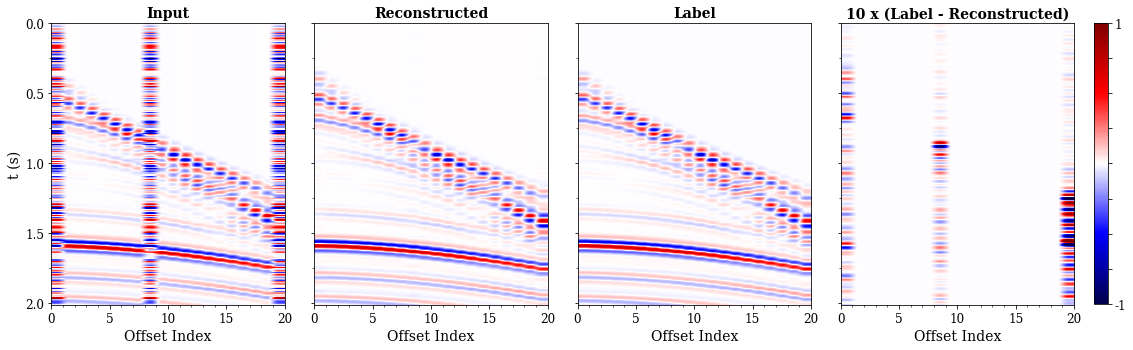

In [17]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
mask_label = test_data.encodings['mask_label'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    f, ax = plt.subplots(1, 4, figsize=(15, 7.5), sharey=True, sharex=False)
    f.tight_layout()
    ax[0].imshow(X.detach().swapaxes(0, 1) - X.mean(dim=1), aspect=12, vmin=-1, vmax=1, cmap='seismic', 
                extent=[0, 20, 271*8/1000, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].set_xlabel("Offset Index")
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0].set_ylabel("t (s)")
    output = y
    ax[1].imshow(output.detach().swapaxes(0, 1) - output.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[1].set_title("Reconstructed", fontsize=14)
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1].set_xlabel("Offset Index")
    ax[2].imshow(z.detach().swapaxes(0, 1) - z.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[2].set_title("Label", fontsize=14)
    ax[2].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[2].set_xlabel("Offset Index")
    diff = 10 * (z - output)
    im4 = ax[3].imshow(diff.detach().swapaxes(0, 1), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                      extent=[0, 20, 271*8/1000, 0])
    ax[3].set_title("10 x (Label - Reconstructed)", fontsize=14)
    ax[3].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[3].set_xlabel("Offset Index")
    plt.ylim(2.01, 0)
        
    cbar_ax = f.add_axes([1, 0.255, 0.0125, 0.52])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

## Finalize

In [18]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/pretrain/
Path exists. Overwrite? (y/n)n
Saving failed.


## References

Devlin, J., M.-W. Chang, K. Lee, and K. Toutanova, 2018, Bert: Pre-training of deep bidirectional transformers for language understanding: arXiv preprint arXiv:1810.04805.

Harsuko, R., and T. Alkhalifah, 2022, Storseismic: An approach to pre-train a neural network to store seismic data features: 83rd EAGE Annual Conference & Exhibition, European Association of Geoscientists & Engineers, 1–5.

Xiong, R., Yang, Y., He, D., Zheng, K., Zheng, S., Xing, C., Zhang, H., Lan, Y., Wang, L. and Liu, T., 2020, November. On layer normalization in the transformer architecture. In International Conference on Machine Learning (pp. 10524-10533). PMLR.